# Dask start

Not to forget to update dask server address:

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45921")

# Import

In [2]:
! pip install -q wandb

In [3]:
import os
import torch
import pytorch_lightning as pl
import wandb

import matplotlib.pyplot as plt

In [4]:
import sys
sys.path.insert(1, '../..')

In [5]:
from geoTrainFlow.source.dataModule import DataModule
from geoTrainFlow.source.main_training_module import TrainingModule

In [6]:
from geoTrainFlow.source.models.lin_reg import lin_regr_model

In [7]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Open data

In [8]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [9]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [10]:
batch_size = 4
img_height = 45
img_width = 40

In [11]:
%%time
features_to_add_to_sample = ['temp', 'temp_var', 'rho_ct_ct', 'diff_temp_sqr']
auxiliary_features = []
all_data_2D = DataModule(PERSISTENT_BUCKET, data_dict, '2D', features_to_add_to_sample, auxiliary_features, \
                         img_height, img_width, batch_size=batch_size, load_data=True)

CPU times: user 341 µs, sys: 93 µs, total: 434 µs
Wall time: 439 µs


# Experiment launching routine

In [12]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from geoTrainFlow.source.callbacks import LogPredictionsCallback, LogFirstWeightCallback

In [13]:
def run_experiment(config, project) :
    # initialize Weigth&Biases logger
    wandb_logger = pl.loggers.WandbLogger(name=config['model_label']+'_'+config['version'], \
                               version=config['model_label']+'_'+config['version'],\
                               project=project, config=config, resume=False, log_model=True, offline=False)
    
    # initialize the torch NN model according to config
    torch_model = eval(config['torch_model'])(**config['torch_model_params'])
    # initialize the training module according to experiment param
    pylight_module = TrainingModule(torch_model, **config['experiment_params'])
    
    # Callbacks :
    
    # save checkpoints
    checkpoint_callback = ModelCheckpoint(monitor="loss_train", save_last=True)  
    
    # stop when the validation loss reaches its min
    early_stopping_callback = EarlyStopping(monitor="loss_validation", mode="min")
    
    # save example snapshots of prediction in W&B logs (for easy visual inspection of predictions)
    log_predictions_callback = LogPredictionsCallback(wandb_logger, config['experiment_params']['output_features'][0])
    
    # log first weight of the model during the training 
    log_first_weight_callback = LogFirstWeightCallback(wandb_logger)
    
    # initialize the trained
    trainer = pl.Trainer(**config['training_params'], logger=wandb_logger, 
                     callbacks=[early_stopping_callback, checkpoint_callback,log_predictions_callback,log_first_weight_callback],
                     accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
    
    # lauch training
    trainer.fit(model = pylight_module, datamodule=eval(config['datamodule']))
    
    # get predictions 
    test_datamodule = eval(config['datamodule'])
    test_datamodule.setup(stage='test')
    trainer.predict(model = pylight_module, dataloaders=test_datamodule.test_dataloader())
    # run tests
    test_datamodule.setup(stage='test')
    trainer.test(model = pylight_module, datamodule=test_datamodule)
    
    # finalize logger
    wandb.finish()

# Runs

In [14]:
wandb.finish()

In [15]:
project_name = 'geoTrainFlow'

In [16]:
configs = list()

## Linear regression

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anagorb63. Use `wandb login --relogin` to force relogin


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory ./geoTrainFlow/LinReg_test/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model |

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 162it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    corr_coef_temp_var     │    0.7142813205718994     │    0.7579474449157715     │    0.7851200103759766     │
│    loss_grad_temp_var     │    474.08404541015625     │     258.9123840332031     │       1318.16796875       │
│     loss_val_temp_var     │     10.91286849975586     │    11.356195449829102     │    31.364906311035156     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    corr_coef_temp_var     │     0.804874837398529     │    0.5345508456230164     │    0.5986316204071045     │
│    loss_grad_temp_var     │     391.7599792480469     │    239.28179931640625     │    215.95724487304688     │
│     loss_val_temp_var     │    10.024372100830078     │     4.018875598907471     │    3.3815054893493652     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 6        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    corr_coef_temp_var     │    0.7389957904815674     │
│    loss_grad_temp_var     │      538.30126953125      │
│     loss_val_temp_var     │    13.471725463867188     │
└───────────────────────────┴───────────────────────────┘

corr_coef_temp_var/dataloader_idx_0,▁
corr_coef_temp_var/dataloader_idx_1,▁
corr_coef_temp_var/dataloader_idx_2,▁
corr_coef_temp_var/dataloader_idx_3,▁
corr_coef_temp_var/dataloader_idx_4,▁
corr_coef_temp_var/dataloader_idx_5,▁
corr_coef_temp_var/dataloader_idx_6,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
first_weight,▁▃▅▆▆▇▇▇████████
loss_grad_temp_var/dataloader_idx_0,▁
loss_grad_temp_var/dataloader_idx_1,▁


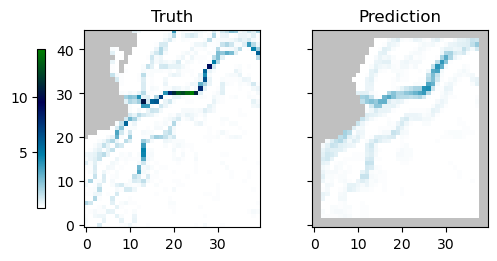

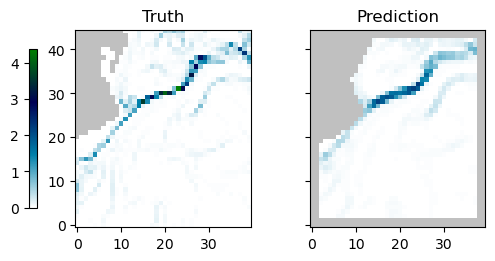

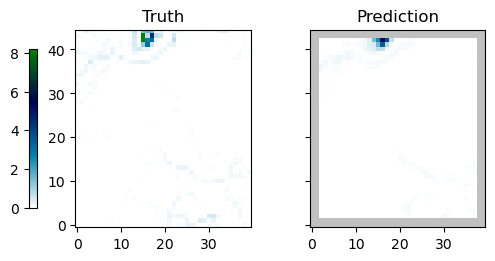

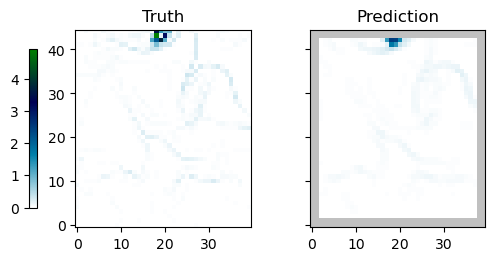

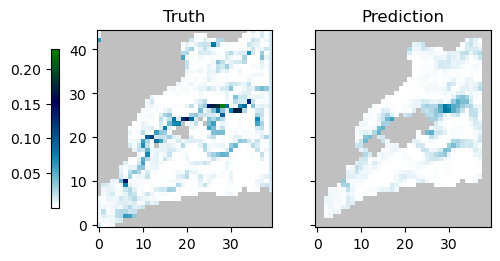

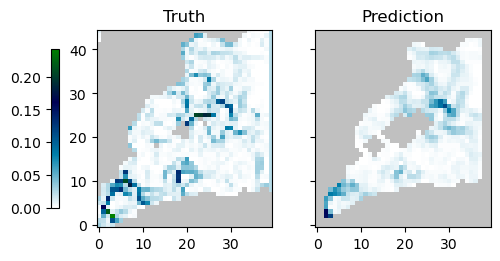

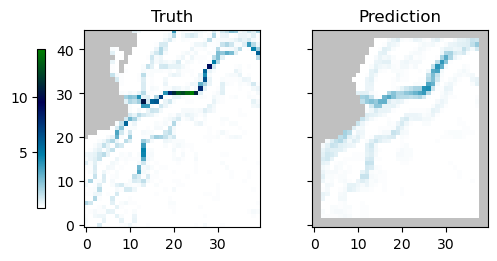

In [17]:
configs.append(dict({'model_label' : 'LinReg',
                'version' : 'test',
                'torch_model' : 'lin_regr_model',
                'datamodule' : 'all_data_2D',
                'torch_model_params' : dict({'data_geometry' : '2D',\
                                            'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'experiment_params' : dict({'input_features'  : ['diff_temp_sqr'],
                                        'output_features'  : ['temp_var'],
                                        'output_units' : None,
                                        'loss' : torch.nn.functional.huber_loss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,
                                        'loss_normalization' : False}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))
run_experiment(configs[-1], project_name)

## FCNN

In [ ]:
# configs.append(dict({'model_label' : 'FCNN',
#                 'version' : '3D_patch3-3_MSELoss_inNorm_outnondim',
#                 'torch_model' : 'FCNN',
#                 'datamodule' : 'all_data_3D',
#                 'torch_model_params' : dict({'data_geometry' : '3D',\
#                                             'nb_of_input_features' : 1, \
#                                             'nb_of_output_features' : 1, \
#                                             'input_patch_size' : 3,
#                                             'output_patch_size' : 3, 
#                                             'int_layer_width' : 50}),
#                 'module_params' : dict({'input_features'  : ['temp'],
#                                         'output_features'  : ['temp_var'],
#                                         'output_units' : ['diff_temp_sqr'],
#                                         'input_normalization_features' : ['sqrt_filtered_diff_temp_sqr'],
#                                         'loss' : torch.nn.functional.mse_loss,
#                                         'optimizer' : torch.optim.Adam,
#                                         'learning_rate' : 1e-4,
#                                         'loss_normalization' : False}),
#                 'training_params' : dict({'max_epochs' : 100,
#                                           'limit_train_batches' : 1.0})
#                }))
# run_experiment(configs[-1], project_name)

## CNN

In [ ]:
# configs.append(dict({'model_label' : 'CNN',
#                 'version' : 'kernel3_MSELossNorm_inNorm_outnondim',
#                 'torch_model' : 'CNN',
#                 'datamodule' : 'all_data_3D',
#                 'torch_model_params' : dict({'data_geometry' : '3D',\
#                                             'nb_of_input_features' : 1, \
#                                             'nb_of_output_features' : 1, \
#                                             'kernel_size' : 3,
#                                             'int_layer_width' : 64}),
#                 'module_params' : dict({'input_features'  : ['temp'],
#                                         'output_features'  : ['temp_var'],
#                                         'output_units' : ['diff_temp_sqr'],
#                                         'input_normalization_features' : ['sqrt_filtered_diff_temp_sqr'],
#                                         'loss' : torch.nn.functional.mse_loss,
#                                         'optimizer' : torch.optim.Adam,
#                                         'learning_rate' : 1e-3,
#                                         'loss_normalization' : True}),
#                 'training_params' : dict({'max_epochs' : 100,
#                                           'limit_train_batches' : 1.0})
#                }))
# run_experiment(configs[-1], project_name)

# Check the metrics and tests

The metrics monitored during the training and after-training tests results can be found on https://wandb.ai/anagorb63/tests?workspace=user-anagorb63